In [1]:
import argparse
import logging
import math
import multiprocessing
import os
import sys
import time
from datetime import datetime

import cupy
import numpy as np
import ray
from ray import tune
from ray.tune import track, trial
from ray.tune.logger import TBXLogger
from ray.tune.schedulers import (ASHAScheduler, AsyncHyperBandScheduler, PopulationBasedTraining)
from ray.tune.utils import get_pinned_object, pin_in_object_store

from rapids_csp import RapidsCloudML
from rcml import dataset_csp

_DEBUG = bool(os.environ.get("_DEBUG", False))

In [2]:
def configure_root_logger():

    # cuml, cupy set up logging. Clear out the handlers
    while logging.root.hasHandlers():
        logging.root.removeHandler(logging.root.handlers[0])

    # Configure a console handler to be debug only
    ch = logging.StreamHandler(stream=sys.stdout)
    ch.setLevel(logging.INFO)
    ch.setFormatter(logging.Formatter(logging.BASIC_FORMAT))

    # This must be before rapids_csp import
    logging.basicConfig(level=logging.DEBUG, handlers=[ch])


configure_root_logger()


# My fix to return a callable
def loguniform(min_bound, max_bound, base=10):
    """Sugar for sampling in different orders of magnitude.

    Args:
        min_bound (float): Lower boundary of the output interval (1e-4)
        max_bound (float): Upper boundary of the output interval (1e-2)
        base (float): Base of the log. Defaults to 10.
    """
    logmin = np.log(min_bound) / np.log(base)
    logmax = np.log(max_bound) / np.log(base)

    def apply_log():
        return base**(np.random.uniform(logmin, logmax))

    return apply_log

In [3]:
def trial_str_creator(trial: ray.tune.trial.Trial):
    return trial.trainable_name

In [4]:
class BaseTrainTransformer(tune.Trainable):
    @property
    def static_config(self) -> dict:
        return getattr(self, "_static_config", {})

    def _setup(self, config: dict):

        configure_root_logger()

        self.logger = logging.getLogger("BaseTrainTransformer")
        fh = logging.FileHandler(filename="./training.log")
        fh.setLevel(logging.DEBUG)

        # Add the file handler to the logger
        self.logger.addHandler(fh)

        try:
            self.logger.debug("ray.get_gpu_ids(): {}".format(ray.get_gpu_ids()))
            self.logger.debug("CUDA_VISIBLE_DEVICES: {}".format(os.environ["CUDA_VISIBLE_DEVICES"]))
        except Exception:
            pass

        self.data_dir = data_dir
        self.model_type = model_type
        self.compute = compute
        CSP_paths = {"train_data": self.data_dir}

        self._rcml = RapidsCloudML(cloud_type="local",
                                   model_type=self.model_type,
                                   compute_type=self.compute,
                                   n_workers=self.static_config["num_workers"],
                                   CSP_paths=CSP_paths,
                                   parent_logger=self.logger)

        # environment check
        self._rcml.environment_check()

        # ingest data [ post pre-processing ]
        self._dataset, self._col_labels, self._y_label, ingest_time = self._rcml.load_data(filename=self.static_config['dataset_filename'])
        self._rcml.query_memory()

        # classification objective requires int32 label for cuml random forest
        self._dataset[self._y_label] = self._dataset[self._y_label].astype('int32')

        self._build(config)

    def _build(self, new_config):
        self._model_params = {
            'max_depth': int(new_config["max_depth"]),
            'n_estimators': int(new_config["n_estimators"]),
            'max_features': float(new_config["max_features"]),
            'n_bins': 16,  #args.n_bins,
            'seed': time.time(),
        }

        self._global_best_model = None
        self._global_best_test_accuracy = 0

    def _train(self):

        iteration = getattr(self, "iteration", 0)

        self.logger.debug("Epoch: {}".format(iteration))

        # split data
        X_train, X_test, y_train, y_test, split_time = self._rcml.split_data(self._dataset, self._y_label, random_state=iteration, shuffle=True)
        # split_time_per_fold += [ round( split_time, 4)]

        # train model
        trained_model, training_time = self._rcml.train_model(X_train, y_train, self._model_params)
        # train_time_per_fold += [ round( training_time, 4) ]

        # evaluate perf
        test_accuracy, infer_time = self._rcml.evaluate_test_perf(trained_model, X_test, y_test)
        # accuracy_per_fold += [ round( test_accuracy, 4) ]
        # infer_time_per_fold += [ round( infer_time, 4) ]

        # update best model [ assumes maximization of perf metric ]
        if test_accuracy > self._global_best_test_accuracy:
            self._global_best_test_accuracy = test_accuracy
            self._global_best_model = trained_model

        self.logger.info("test_accuracy: {}".format(test_accuracy))

        return {
            "test_accuracy": test_accuracy,
            "train_time": round(training_time, 4),
            "infer_time": round(infer_time, 4),
            "is_bad": not math.isfinite(test_accuracy),
        }

    def _save(self, checkpoint_dir):
        checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")

        self.logger.debug("Saving checkpoint to: '{}'".format(checkpoint_path))

        self._rcml.save_best_model(checkpoint_path, self._global_best_model)
        return checkpoint_path

    def _restore(self, checkpoint_path):

        self.logger.debug("Restoring model from: '{}'".format(checkpoint_path))

    def reset_config(self, new_config):

        self.logger.debug("Resetting config")
        # Rebuild the config dependent stuff
        self._build(new_config)

        self.config = new_config
        return True

In [5]:
def build_search_alg(param_ranges: dict):

    search_alg = None

    if search_alg == "BayesOpt":
        from ray.tune.suggest.bayesopt import BayesOptSearch

        search_alg = BayesOptSearch(param_ranges,
                                    max_concurrent=max_concurrent,
                                    metric="test_accuracy",
                                    mode="max",
                                    utility_kwargs={
                                        "kind": "ucb",
                                        "kappa": 2.5,
                                        "xi": 0.0
                                    })

    elif search_alg == "SkOpt":

        from skopt import Optimizer
        from skopt.space import Real, Integer
        from ray.tune.suggest.skopt import SkOptSearch

        opt_params = [
            Integer(param_ranges["n_estimators"][0], param_ranges["n_estimators"][1]),
            Integer(param_ranges["max_depth"][0], param_ranges["max_depth"][1]),
            Real(param_ranges["max_features"][0], param_ranges["max_features"][1], prior="log-uniform"),
        ]

        optimizer = Optimizer(opt_params)

        search_alg = SkOptSearch(
            optimizer,
            list(param_ranges.keys()),
            max_concurrent=max_concurrent,
            metric="test_accuracy",
            mode="max",
            #  points_to_evaluate=previously_run_params,
            #  evaluated_rewards=known_rewards,
        )

    elif search_alg == "Nevergrad":
        from ray.tune.suggest.nevergrad import NevergradSearch
        import nevergrad as ng
        from nevergrad.optimization import optimizerlib
        # from nevergrad import instrumentation as inst

        instrumentation = ng.instrumentation.Instrumentation(
            n_estimators=ng.instrumentation.var.Scalar(dtype=int).bounded(param_ranges["n_estimators"][0], param_ranges["n_estimators"][1]),
            max_depth=ng.instrumentation.var.Scalar(dtype=int).bounded(param_ranges["max_depth"][0], param_ranges["max_depth"][1]),
            max_features=ng.instrumentation.var.Log(a_min=param_ranges["max_features"][0], a_max=param_ranges["max_features"][1]),
        )

        optimizer = optimizerlib.OnePlusOne(instrumentation)

        search_alg = NevergradSearch(optimizer, None, max_concurrent=max_concurrent, metric="test_accuracy", mode="max")

    return search_alg

In [6]:
%tb
start_time = time.time()

num_samples = 1
model_type = "RandomForest"
compute = "GPU"
data_dir = "/home/hyperopt/RayTune/aws-sagemaker-gtc-2020/raytune/data/"
CV_folds = 50
search_alg = "SkOpt"
sched_alg = "PBT"
num_rows = 10000000
max_concurrent = -1

# HPO Param ranges
n_estimators_range = (50, 1000)
max_depth_range = (2, 18)
max_features_range = (0.1, 0.8)

hpo_ranges = {
    "n_estimators": n_estimators_range,
    "max_depth": max_depth_range,
    "max_features": max_features_range,
}

# Ensure the dataset is setup
dataset_config = {
    'dataset_name': "airline",
    'nrows': num_rows,  # 115000000
    'delayed_threshold': 10,
    'remote_URL': 'http://kt.ijs.si/elena_ikonomovska/datasets/airline/airline_14col.data.bz2',
    'local_cache_dir': "/home/hyperopt/RayTune/aws-sagemaker-gtc-2020/raytune/data/",
    'upload_destination': ['rapids-csp', 'data'],  # bucket, folder
}

# Test local
local_dataset = dataset_csp.DatasetCSP(dataset_config=dataset_config, cloud_type="local")

# Ensure its loaded
# local_dataset.prepare()

data_dir = os.path.abspath(data_dir)

if _DEBUG:
    # Only use 1 GPU when
    ray.init(local_mode=True, num_gpus=1)
    num_samples = 2
else:
    ray.init(webui_host="0.0.0.0")

if max_concurrent == -1:
    if compute == "GPU":
        max_concurrent = cupy.cuda.runtime.getDeviceCount()
    else:
        raise Exception("For CPU, must specify max_concurrent value")

cpu_per_sample = int(multiprocessing.cpu_count() / max_concurrent)

No traceback available to show.
2020-03-24 16:56:19,072	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-24 16:56:19,074	INFO resource_spec.py:212 -- Starting Ray with 23.14 GiB memory available for workers and up to 11.58 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-24 16:56:19,523	INFO services.py:1078 -- View the Ray dashboard at 172.17.0.2:8265
2020-03-24 16:56:19,528	WARNING services.py:1403 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67100672 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.


In [7]:

# # Limit the number of rows. (MDD: This doesnt appear to work unfortunately)
# reporter = CLIReporter(max_progress_rows=10)
# # Add a custom metric column, in addition to the default metrics.
# # Note that this must be a metric that is returned in your training results.
# reporter.add_metric_column("validation_loss")

search_alg = build_search_alg(hpo_ranges)

sched = None

if sched_alg == "PBT":

    sched = PopulationBasedTraining(
        time_attr="training_iteration",
        metric="test_accuracy",
        mode="max",
        perturbation_interval=1,
        hyperparam_mutations={
            # distribution for resampling
            "n_estimators": lambda: np.random.randint(n_estimators_range[0], n_estimators_range[1]),
            "max_depth": lambda: np.random.randint(max_depth_range[0], max_depth_range[1]),
            "max_features": loguniform(max_features_range[0], max_features_range[1]),
        })
elif sched_alg == "AsyncHyperBand":
    sched = AsyncHyperBandScheduler(time_attr="training_iteration",
                                    metric="test_accuracy",
                                    mode="max",
                                    max_t=3,
                                    grace_period=1,
                                    reduction_factor=3,
                                    brackets=3)

exp_name = datetime.today().strftime("%Y-%m-%d_%H-%M-%S") + "__"

if exp_name is not None:
    exp_name += exp_name
else:
    exp_name += "{}_{}_CV-{}_{}M_SAMP-{}".format("RF" if model_type == "RandomForest" else "XGB", compute, CV_folds,
                                                 int(num_rows / 1000000), num_samples)

    if search_alg is not None:
        exp_name += "_{}".format(search_alg)
    if sched_alg is not None:
        exp_name += "_{}".format(sched_alg)

static_config = {
    "dataset_filename": os.path.basename(local_dataset.train_path),
    "num_workers": cpu_per_sample if compute == "CPU" else 1,
}

In [8]:
class WrappedTrainable(BaseTrainTransformer):
    def __init__(self, *args, **kwargs):

        self._static_config = static_config

        super().__init__(*args, **kwargs)

analysis = tune.run(
    WrappedTrainable,
    name=exp_name,
    scheduler=sched,
    search_alg=search_alg,
    stop={
        "training_iteration": CV_folds,
        "is_bad": True,
    },
    resources_per_trial={
        "cpu": cpu_per_sample,
        "gpu": int(compute == "GPU")
    },
    # loggers=ray.tune.logger.DEFAULT_LOGGERS,
    num_samples=num_samples,
    checkpoint_at_end=True,
    # checkpoint_freq=5,
    keep_checkpoints_num=1,
    local_dir="./.results",
    trial_name_creator=trial_str_creator,
    checkpoint_score_attr="test_accuracy",
    # reuse_actors=True,  # Set to true if reset_config() is implemented
    config={
        "n_estimators": tune.randint(n_estimators_range[0], n_estimators_range[1]),
        "max_depth": tune.randint(max_depth_range[0], max_depth_range[1]),
        "max_features": tune.loguniform(max_features_range[0], max_features_range[1]),
        "dataset_filename": os.path.basename(local_dataset.train_path),
        "num_workers": cpu_per_sample if compute == "CPU" else 1,
    },
    verbose=2,
    raise_on_failed_trial=False)

Trial name,status,loc,n_estimators,max_features,max_depth
WrappedTrainable,RUNNING,,,,


(pid=664) INFO:numba.cuda.cudadrv.driver:init
Result for WrappedTrainable:
  date: 2020-03-24_16-56-32
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0722
  is_bad: false
  iterations_since_restore: 1
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7351605296134949
  time_since_restore: 8.750439643859863
  time_this_iter_s: 8.750439643859863
  time_total_s: 8.750439643859863
  timestamp: 1585068992
  timesteps_since_restore: 0
  train_time: 8.5605
  training_iteration: 1
  trial_id: 627212e2
  
(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7351605296134949


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,8.75044,1


Result for WrappedTrainable:
  date: 2020-03-24_16-56-41
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0759
  is_bad: false
  iterations_since_restore: 2
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7352445125579834
  time_since_restore: 17.49007487297058
  time_this_iter_s: 8.739635229110718
  time_total_s: 17.49007487297058
  timestamp: 1585069001
  timesteps_since_restore: 0
  train_time: 8.5539
  training_iteration: 2
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,17.4901,2


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7352445125579834
Result for WrappedTrainable:
  date: 2020-03-24_16-56-50
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0681
  is_bad: false
  iterations_since_restore: 3
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.734634518623352
  time_since_restore: 26.21769905090332
  time_this_iter_s: 8.72762417793274
  time_total_s: 26.21769905090332
  timestamp: 1585069010
  timesteps_since_restore: 0
  train_time: 8.5517
  training_iteration: 3
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,26.2177,3


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.734634518623352
Result for WrappedTrainable:
  date: 2020-03-24_16-56-58
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0649
  is_bad: false
  iterations_since_restore: 4
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.735276997089386
  time_since_restore: 34.955745697021484
  time_this_iter_s: 8.738046646118164
  time_total_s: 34.955745697021484
  timestamp: 1585069018
  timesteps_since_restore: 0
  train_time: 8.565
  training_iteration: 4
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,34.9557,4


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.735276997089386
Result for WrappedTrainable:
  date: 2020-03-24_16-57-07
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.061
  is_bad: false
  iterations_since_restore: 5
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7354419827461243
  time_since_restore: 43.7281653881073
  time_this_iter_s: 8.772419691085815
  time_total_s: 43.7281653881073
  timestamp: 1585069027
  timesteps_since_restore: 0
  train_time: 8.6015
  training_iteration: 5
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,43.7282,5


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7354419827461243
Result for WrappedTrainable:
  date: 2020-03-24_16-57-16
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0595
  is_bad: false
  iterations_since_restore: 6
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.735306978225708
  time_since_restore: 52.498003244400024
  time_this_iter_s: 8.769837856292725
  time_total_s: 52.498003244400024
  timestamp: 1585069036
  timesteps_since_restore: 0
  train_time: 8.602
  training_iteration: 6
  trial_id: 627212e2
  (pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.735306978225708



Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,52.498,6


Result for WrappedTrainable:
  date: 2020-03-24_16-57-25
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0601
  is_bad: false
  iterations_since_restore: 7
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7350149750709534
  time_since_restore: 61.27258324623108
  time_this_iter_s: 8.774580001831055
  time_total_s: 61.27258324623108
  timestamp: 1585069045
  timesteps_since_restore: 0
  train_time: 8.6042
  training_iteration: 7
  trial_id: 627212e2
  
(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7350149750709534


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,61.2726,7


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7353460192680359
Result for WrappedTrainable:
  date: 2020-03-24_16-57-33
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0599
  is_bad: false
  iterations_since_restore: 8
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7353460192680359
  time_since_restore: 70.05354905128479
  time_this_iter_s: 8.780965805053711
  time_total_s: 70.05354905128479
  timestamp: 1585069053
  timesteps_since_restore: 0
  train_time: 8.6111
  training_iteration: 8
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,70.0535,8


Result for WrappedTrainable:
(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7356675267219543  date: 2020-03-24_16-57-42
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0602
  is_bad: false
  iterations_since_restore: 9
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7356675267219543
  time_since_restore: 78.82952523231506
  time_this_iter_s: 8.775976181030273
  time_total_s: 78.82952523231506
  timestamp: 1585069062
  timesteps_since_restore: 0
  train_time: 8.6072
  training_iteration: 9
  trial_id: 627212e2
  



Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,78.8295,9


Result for WrappedTrainable:
  date: 2020-03-24_16-57-51
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0601
  is_bad: false
  iterations_since_restore: 10
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7358865141868591
  time_since_restore: 87.61056542396545
  time_this_iter_s: 8.78104019165039
  time_total_s: 87.61056542396545
  timestamp: 1585069071
  timesteps_since_restore: 0
  train_time: 8.6122
  training_iteration: 10
  trial_id: 627212e2
  
(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7358865141868591


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,87.6106,10


Result for WrappedTrainable:
  date: 2020-03-24_16-58-00
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0602
  is_bad: false
  iterations_since_restore: 11
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7354205250740051
  time_since_restore: 96.39790272712708
  time_this_iter_s: 8.787337303161621
  time_total_s: 96.39790272712708
  timestamp: 1585069080
  timesteps_since_restore: 0
  train_time: 8.619
  training_iteration: 11
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,96.3979,11


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7354205250740051
Result for WrappedTrainable:
  date: 2020-03-24_16-58-09
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0608
  is_bad: false
  iterations_since_restore: 12
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7356594800949097
  time_since_restore: 105.19043183326721
  time_this_iter_s: 8.792529106140137
  time_total_s: 105.19043183326721
  timestamp: 1585069089
  timesteps_since_restore: 0
  train_time: 8.6232
  training_iteration: 12
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,105.19,12


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7356594800949097
Result for WrappedTrainable:
  date: 2020-03-24_16-58-17
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0621
  is_bad: false
  iterations_since_restore: 13
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7353230118751526
  time_since_restore: 113.99699139595032
  time_this_iter_s: 8.806559562683105
  time_total_s: 113.99699139595032
  timestamp: 1585069097
  timesteps_since_restore: 0
  train_time: 8.6333
  training_iteration: 13
  trial_id: 627212e2
  
(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7353230118751526


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,113.997,13


Result for WrappedTrainable:
  date: 2020-03-24_16-58-26
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0603
  is_bad: false
  iterations_since_restore: 14
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7352030277252197
  time_since_restore: 122.80207538604736
  time_this_iter_s: 8.805083990097046
  time_total_s: 122.80207538604736
  timestamp: 1585069106
  timesteps_since_restore: 0
  train_time: 8.6342
  training_iteration: 14
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,122.802,14


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7352030277252197
Result for WrappedTrainable:
  date: 2020-03-24_16-58-35
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0601
  is_bad: false
  iterations_since_restore: 15
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7352575063705444
  time_since_restore: 131.60943627357483
  time_this_iter_s: 8.807360887527466
  time_total_s: 131.60943627357483
  timestamp: 1585069115
  timesteps_since_restore: 0
  train_time: 8.638
  training_iteration: 15
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,131.609,15


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7352575063705444
Result for WrappedTrainable:
  date: 2020-03-24_16-58-44
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.06
  is_bad: false
  iterations_since_restore: 16
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7352434992790222
  time_since_restore: 140.4034583568573
  time_this_iter_s: 8.79402208328247
  time_total_s: 140.4034583568573
  timestamp: 1585069124
  timesteps_since_restore: 0
  train_time: 8.625
  training_iteration: 16
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,140.403,16


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7352434992790222
Result for WrappedTrainable:
  date: 2020-03-24_16-58-53
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0605
  is_bad: false
  iterations_since_restore: 17
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7355934977531433
  time_since_restore: 149.2143795490265
  time_this_iter_s: 8.81092119216919
  time_total_s: 149.2143795490265
  timestamp: 1585069133
  timesteps_since_restore: 0
  train_time: 8.6404
  training_iteration: 17
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,149.214,17


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7355934977531433
Result for WrappedTrainable:
  date: 2020-03-24_16-59-02
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0602
  is_bad: false
  iterations_since_restore: 18
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7352545261383057
  time_since_restore: 158.02079916000366
  time_this_iter_s: 8.806419610977173
  time_total_s: 158.02079916000366
  timestamp: 1585069142
  timesteps_since_restore: 0
  train_time: 8.6367
  training_iteration: 18
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,158.021,18


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7352545261383057
Result for WrappedTrainable:
  date: 2020-03-24_16-59-10
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0603
  is_bad: false
  iterations_since_restore: 19
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7353410124778748
  time_since_restore: 166.8161141872406
  time_this_iter_s: 8.795315027236938
  time_total_s: 166.8161141872406
  timestamp: 1585069150
  timesteps_since_restore: 0
  train_time: 8.6237
  training_iteration: 19
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,166.816,19


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7353410124778748
Result for WrappedTrainable:
  date: 2020-03-24_16-59-19
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0602
  is_bad: false
  iterations_since_restore: 20
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7352499961853027
  time_since_restore: 175.62551879882812
  time_this_iter_s: 8.809404611587524
  time_total_s: 175.62551879882812
  timestamp: 1585069159
  timesteps_since_restore: 0
  train_time: 8.6418
  training_iteration: 20
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,175.626,20


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7352499961853027
Result for WrappedTrainable:
  date: 2020-03-24_16-59-28
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0606
  is_bad: false
  iterations_since_restore: 21
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7351624965667725
  time_since_restore: 184.42883968353271
  time_this_iter_s: 8.80332088470459
  time_total_s: 184.42883968353271
  timestamp: 1585069168
  timesteps_since_restore: 0
  train_time: 8.6287
  training_iteration: 21
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,184.429,21


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7351624965667725
Result for WrappedTrainable:
  date: 2020-03-24_16-59-37
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0609
  is_bad: false
  iterations_since_restore: 22
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7353760004043579
  time_since_restore: 193.22984552383423
  time_this_iter_s: 8.801005840301514
  time_total_s: 193.22984552383423
  timestamp: 1585069177
  timesteps_since_restore: 0
  train_time: 8.632
  training_iteration: 22
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,193.23,22


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7353760004043579
Result for WrappedTrainable:
  date: 2020-03-24_16-59-46
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0605
  is_bad: false
  iterations_since_restore: 23
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7356535196304321
  time_since_restore: 202.0369553565979
  time_this_iter_s: 8.807109832763672
  time_total_s: 202.0369553565979
  timestamp: 1585069186
  timesteps_since_restore: 0
  train_time: 8.6315
  training_iteration: 23
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,202.037,23


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7356535196304321
Result for WrappedTrainable:
  date: 2020-03-24_16-59-54
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.061
  is_bad: false
  iterations_since_restore: 24
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.735371470451355
  time_since_restore: 210.83695554733276
  time_this_iter_s: 8.800000190734863
  time_total_s: 210.83695554733276
  timestamp: 1585069194
  timesteps_since_restore: 0
  train_time: 8.6289
  training_iteration: 24
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,210.837,24


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.735371470451355
Result for WrappedTrainable:
  date: 2020-03-24_17-00-03
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0614
  is_bad: false
  iterations_since_restore: 25
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7353695034980774
  time_since_restore: 219.65000176429749
  time_this_iter_s: 8.813046216964722
  time_total_s: 219.65000176429749
  timestamp: 1585069203
  timesteps_since_restore: 0
  train_time: 8.6439
  training_iteration: 25
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,219.65,25


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7353695034980774
Result for WrappedTrainable:
  date: 2020-03-24_17-00-12
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0607
  is_bad: false
  iterations_since_restore: 26
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7350900173187256
  time_since_restore: 228.45145511627197
  time_this_iter_s: 8.801453351974487
  time_total_s: 228.45145511627197
  timestamp: 1585069212
  timesteps_since_restore: 0
  train_time: 8.6325
  training_iteration: 26
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,228.451,26


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7350900173187256
Result for WrappedTrainable:
  date: 2020-03-24_17-00-21
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0613
  is_bad: false
  iterations_since_restore: 27
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7355524897575378
  time_since_restore: 237.25284099578857
  time_this_iter_s: 8.801385879516602
  time_total_s: 237.25284099578857
  timestamp: 1585069221
  timesteps_since_restore: 0
  train_time: 8.6313
  training_iteration: 27
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,237.253,27


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7355524897575378
Result for WrappedTrainable:
  date: 2020-03-24_17-00-30
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.061
  is_bad: false
  iterations_since_restore: 28
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7353125214576721
  time_since_restore: 246.0602307319641
  time_this_iter_s: 8.807389736175537
  time_total_s: 246.0602307319641
  timestamp: 1585069230
  timesteps_since_restore: 0
  train_time: 8.6378
  training_iteration: 28
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,246.06,28


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7353125214576721
Result for WrappedTrainable:
  date: 2020-03-24_17-00-38
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0599
  is_bad: false
  iterations_since_restore: 29
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7349550127983093
  time_since_restore: 254.86125707626343
  time_this_iter_s: 8.801026344299316
  time_total_s: 254.86125707626343
  timestamp: 1585069238
  timesteps_since_restore: 0
  train_time: 8.6306
  training_iteration: 29
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,254.861,29


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7349550127983093
Result for WrappedTrainable:
  date: 2020-03-24_17-00-47
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0609
  is_bad: false
  iterations_since_restore: 30
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.734857976436615
  time_since_restore: 263.6661841869354
  time_this_iter_s: 8.804927110671997
  time_total_s: 263.6661841869354
  timestamp: 1585069247
  timesteps_since_restore: 0
  train_time: 8.6369
  training_iteration: 30
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,263.666,30


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.734857976436615
Result for WrappedTrainable:
  date: 2020-03-24_17-00-56
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0759
  is_bad: false
  iterations_since_restore: 31
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7356684803962708
  time_since_restore: 272.4845187664032
  time_this_iter_s: 8.818334579467773
  time_total_s: 272.4845187664032
  timestamp: 1585069256
  timesteps_since_restore: 0
  train_time: 8.6251
  training_iteration: 31
  trial_id: 627212e2
  
(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7356684803962708


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,272.485,31


Result for WrappedTrainable:
  date: 2020-03-24_17-01-05
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.061
  is_bad: false
  iterations_since_restore: 32
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7357125282287598
  time_since_restore: 281.2941744327545
  time_this_iter_s: 8.809655666351318
  time_total_s: 281.2941744327545
  timestamp: 1585069265
  timesteps_since_restore: 0
  train_time: 8.6402
  training_iteration: 32
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,281.294,32


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7357125282287598
Result for WrappedTrainable:
(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7352150082588196  date: 2020-03-24_17-01-14
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.061
  is_bad: false
  iterations_since_restore: 33
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7352150082588196
  time_since_restore: 290.0949447154999
  time_this_iter_s: 8.800770282745361
  time_total_s: 290.0949447154999
  timestamp: 1585069274
  timesteps_since_restore: 0
  train_time: 8.6313
  training_iteration: 33
  trial_id: 627212e2
  



Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,290.095,33


Result for WrappedTrainable:
  date: 2020-03-24_17-01-23
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0614
  is_bad: false
  iterations_since_restore: 34
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.735031008720398
  time_since_restore: 298.9003231525421
  time_this_iter_s: 8.805378437042236
  time_total_s: 298.9003231525421
  timestamp: 1585069283
  timesteps_since_restore: 0
  train_time: 8.6344
  training_iteration: 34
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,298.9,34


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.735031008720398
Result for WrappedTrainable:
  date: 2020-03-24_17-01-31
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0603
  is_bad: false
  iterations_since_restore: 35
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7359179854393005
  time_since_restore: 307.6932089328766
  time_this_iter_s: 8.792885780334473
  time_total_s: 307.6932089328766
  timestamp: 1585069291
  timesteps_since_restore: 0
  train_time: 8.6241
  training_iteration: 35
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,307.693,35


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7359179854393005
Result for WrappedTrainable:
  date: 2020-03-24_17-01-40
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0609
  is_bad: false
  iterations_since_restore: 36
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7347754836082458
  time_since_restore: 316.49847507476807
  time_this_iter_s: 8.80526614189148
  time_total_s: 316.49847507476807
  timestamp: 1585069300
  timesteps_since_restore: 0
  train_time: 8.6335
  training_iteration: 36
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,316.498,36


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7347754836082458
Result for WrappedTrainable:
  date: 2020-03-24_17-01-49
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0614
  is_bad: false
  iterations_since_restore: 37
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7353379726409912
  time_since_restore: 325.2938697338104
  time_this_iter_s: 8.795394659042358
  time_total_s: 325.2938697338104
  timestamp: 1585069309
  timesteps_since_restore: 0
  train_time: 8.6238
  training_iteration: 37
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,325.294,37


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7353379726409912
Result for WrappedTrainable:
  date: 2020-03-24_17-01-58
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0606
  is_bad: false
  iterations_since_restore: 38
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7351800203323364
  time_since_restore: 334.0952389240265
  time_this_iter_s: 8.801369190216064
  time_total_s: 334.0952389240265
  timestamp: 1585069318
  timesteps_since_restore: 0
  train_time: 8.6309
  training_iteration: 38
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,334.095,38


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7351800203323364
Result for WrappedTrainable:
  date: 2020-03-24_17-02-07
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0615
  is_bad: false
  iterations_since_restore: 39
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7353140115737915
  time_since_restore: 342.9018323421478
  time_this_iter_s: 8.806593418121338
  time_total_s: 342.9018323421478
  timestamp: 1585069327
  timesteps_since_restore: 0
  train_time: 8.6369
  training_iteration: 39
  trial_id: 627212e2
  
(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7353140115737915


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,342.902,39


Result for WrappedTrainable:
  date: 2020-03-24_17-02-15
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0607
  is_bad: false
  iterations_since_restore: 40
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7353065013885498
  time_since_restore: 351.70631647109985
  time_this_iter_s: 8.804484128952026
  time_total_s: 351.70631647109985
  timestamp: 1585069335
  timesteps_since_restore: 0
  train_time: 8.629
  training_iteration: 40
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,351.706,40


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7353065013885498
Result for WrappedTrainable:
  date: 2020-03-24_17-02-24
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0626
  is_bad: false
  iterations_since_restore: 41
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7354620099067688
  time_since_restore: 360.50968861579895
  time_this_iter_s: 8.803372144699097
  time_total_s: 360.50968861579895
  timestamp: 1585069344
  timesteps_since_restore: 0
  train_time: 8.6265
  training_iteration: 41
  trial_id: 627212e2
  
(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7354620099067688


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,360.51,41


Result for WrappedTrainable:
  date: 2020-03-24_17-02-33
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.061
  is_bad: false
  iterations_since_restore: 42
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7354614734649658
  time_since_restore: 369.3177225589752
  time_this_iter_s: 8.80803394317627
  time_total_s: 369.3177225589752
  timestamp: 1585069353
  timesteps_since_restore: 0
  train_time: 8.6365
  training_iteration: 42
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,369.318,42


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7354614734649658
Result for WrappedTrainable:
  date: 2020-03-24_17-02-42
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0614
  is_bad: false
  iterations_since_restore: 43
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7350944876670837
  time_since_restore: 378.1216540336609
  time_this_iter_s: 8.803931474685669
  time_total_s: 378.1216540336609
  timestamp: 1585069362
  timesteps_since_restore: 0
  train_time: 8.6322
  training_iteration: 43
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,378.122,43


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7350944876670837
Result for WrappedTrainable:
  date: 2020-03-24_17-02-51
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0615
  is_bad: false
  iterations_since_restore: 44
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7349675297737122
  time_since_restore: 386.9230990409851
  time_this_iter_s: 8.801445007324219
  time_total_s: 386.9230990409851
  timestamp: 1585069371
  timesteps_since_restore: 0
  train_time: 8.6293
  training_iteration: 44
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,386.923,44


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7349675297737122
Result for WrappedTrainable:
  date: 2020-03-24_17-03-00
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0625
  is_bad: false
  iterations_since_restore: 45
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7358065247535706
  time_since_restore: 395.72494888305664
  time_this_iter_s: 8.801849842071533
  time_total_s: 395.72494888305664
  timestamp: 1585069380
  timesteps_since_restore: 0
  train_time: 8.6297
  training_iteration: 45
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,395.725,45


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7358065247535706
Result for WrappedTrainable:
  date: 2020-03-24_17-03-08
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.061
  is_bad: false
  iterations_since_restore: 46
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7352635264396667
  time_since_restore: 404.52513790130615
  time_this_iter_s: 8.800189018249512
  time_total_s: 404.52513790130615
  timestamp: 1585069388
  timesteps_since_restore: 0
  train_time: 8.6284
  training_iteration: 46
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,404.525,46


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7352635264396667
Result for WrappedTrainable:
  date: 2020-03-24_17-03-17
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0608
  is_bad: false
  iterations_since_restore: 47
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7353854775428772
  time_since_restore: 413.3261241912842
  time_this_iter_s: 8.800986289978027
  time_total_s: 413.3261241912842
  timestamp: 1585069397
  timesteps_since_restore: 0
  train_time: 8.6321
  training_iteration: 47
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,413.326,47


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7353854775428772
Result for WrappedTrainable:
  date: 2020-03-24_17-03-26
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0611
  is_bad: false
  iterations_since_restore: 48
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7353450059890747
  time_since_restore: 422.1272518634796
  time_this_iter_s: 8.801127672195435
  time_total_s: 422.1272518634796
  timestamp: 1585069406
  timesteps_since_restore: 0
  train_time: 8.6302
  training_iteration: 48
  trial_id: 627212e2
  
(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7353450059890747


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,422.127,48


Result for WrappedTrainable:
  date: 2020-03-24_17-03-35
  done: false
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0612
  is_bad: false
  iterations_since_restore: 49
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7348985075950623
  time_since_restore: 430.9289574623108
  time_this_iter_s: 8.801705598831177
  time_total_s: 430.9289574623108
  timestamp: 1585069415
  timesteps_since_restore: 0
  train_time: 8.6272
  training_iteration: 49
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,430.929,49


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7348985075950623
Result for WrappedTrainable:
  date: 2020-03-24_17-03-44
  done: true
  experiment_id: 48a4678dee104a0aaee9bd1544377e32
  experiment_tag: 0_max_depth=4,max_features=0.5214,n_estimators=344
  hostname: 00b88c234adf
  infer_time: 0.0609
  is_bad: false
  iterations_since_restore: 50
  node_ip: 172.17.0.2
  pid: 664
  test_accuracy: 0.7356129884719849
  time_since_restore: 439.72650504112244
  time_this_iter_s: 8.797547578811646
  time_total_s: 439.72650504112244
  timestamp: 1585069424
  timesteps_since_restore: 0
  train_time: 8.6265
  training_iteration: 50
  trial_id: 627212e2
  


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,RUNNING,172.17.0.2:664,344,0.521398,4,439.727,50


(pid=664) INFO:BaseTrainTransformer:test_accuracy: 0.7356129884719849


Trial name,status,loc,n_estimators,max_features,max_depth,total time (s),iter
WrappedTrainable,TERMINATED,,344,0.521398,4,439.727,50


2020-03-24 17:03:44,168	INFO tune.py:352 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


In [9]:
dfs = analysis.trial_dataframes

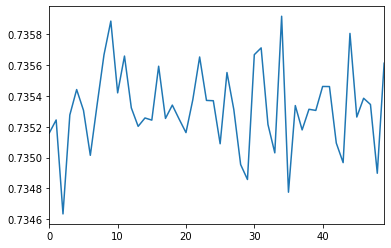

In [19]:
# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.test_accuracy.plot(ax=ax, legend=False)

In [12]:

# Save info into experiment dir
fh = logging.FileHandler(filename=os.path.join(analysis._experiment_dir, "results.log"))
fh.setLevel(logging.DEBUG)

# Add the file handler to the root logger
logging.root.addHandler(fh)

logging.info("Total Duration (sec): {}".format(time.time() - start_time))

logging.info("Min Accuracy: {}".format(analysis.dataframe()["test_accuracy"].min()))
logging.info("Max Accuracy: {}".format(analysis.dataframe()["test_accuracy"].max()))

train_time_df = analysis.dataframe()["train_time"].round(2)
logging.info("Train Time (sec) [min, avg, max, std dev]: {}, {}, {}, {}".format(train_time_df.min(), train_time_df.mean(), train_time_df.max(),
                                                                                train_time_df.std()))

infer_time_df = analysis.dataframe()["infer_time"].round(2)
logging.info("Infer Time (sec) [min, avg, max, std dev]: {}, {}, {}, {}".format(infer_time_df.min(), infer_time_df.mean(), infer_time_df.max(),
                                                                                infer_time_df.std()))

logging.info("Best config is: {}".format(analysis.get_best_config(metric="test_accuracy")))

logging.info("Final Dataframe:")
logging.info(analysis.dataframe().to_csv())

INFO:root:Total Duration (sec): 445.3388521671295
INFO:root:Min Accuracy: 0.7356129884719849
INFO:root:Max Accuracy: 0.7356129884719849
INFO:root:Train Time (sec) [min, avg, max, std dev]: 8.63, 8.63, 8.63, nan
INFO:root:Infer Time (sec) [min, avg, max, std dev]: 0.06, 0.06, 0.06, nan
INFO:root:Best config is: {'n_estimators': 344, 'max_depth': 4, 'max_features': 0.5213979314086207, 'dataset_filename': 'airline_10000000.orc', 'num_workers': 1}
INFO:root:Final Dataframe:
INFO:root:,test_accuracy,train_time,infer_time,is_bad,done,timesteps_total,episodes_total,training_iteration,experiment_id,date,timestamp,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,trial_id,experiment_tag,config/dataset_filename,config/max_depth,config/max_features,config/n_estimators,config/num_workers,logdir
0,0.7356129884719849,8.6265,0.0609,False,True,,,50,48a4678dee104a0aaee9bd1544377e32,2020-03-24_17-03-44,1585069424,8.797547578811647,439.